# Proyek Klasifikasi Gambar: Brain Tumor MRI Dataset
- **Nama:** M Rislan Tristansyah
- **Email:** rislantristansyah@gmail.com
- **ID Dicoding:** m_rislan_tristansyah_82gG

## Import Semua Packages/Library yang Digunakan

In [34]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 26.0rc2
    Uninstalling packaging-26.0rc2:
      Successfully uninstalled packaging-26.0rc2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ray 2.53.0 requires packaging>=24.2, but you have packaging 23.2 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab

In [43]:
import os
import pathlib
import warnings
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import FileLink

# Setup Log & Warning
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)

# Cek GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU aktif:", len(gpus))
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ GPU tidak terdeteksi")

# Import Keras Layers & Tools
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Import Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Cek TensorFlow.js (Kriteria 7)
try:
    import tensorflowjs as tfjs
    print("TensorFlow.js version:", tfjs.__version__)
except ImportError:
    print("Library tensorflowjs belum terinstall (abaikan jika belum perlu convert)")

print("Semua library siap.")

TensorFlow version: 2.19.0
✅ GPU aktif: 2
TensorFlow.js version: 4.22.0
Semua library siap.


## Data Preparation

### Data Loading

In [14]:
# 1. SETUP PATH & CONFIG
data_dir_train = pathlib.Path('/kaggle/input/datasets/masoudnickparvar/brain-tumor-mri-dataset/Training')
data_dir_test = pathlib.Path('/kaggle/input/datasets/masoudnickparvar/brain-tumor-mri-dataset/Testing')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

# 2. KUMPULKAN SEMUA FILE PATH & LABEL
class_names = sorted([item.name for item in data_dir_train.glob('*') if item.is_dir()])
print(f"Kelas ditemukan: {class_names}") # ['glioma', 'meningioma', 'notumor', 'pituitary']

all_filepaths = []
all_labels = []

# Loop untuk mengambil data dari TRAINING folder asli
for label_idx, class_name in enumerate(class_names):
    # Ambil dari folder Training
    train_files = list(data_dir_train.glob(f'{class_name}/*'))
    # Ambil dari folder Testing
    test_files = list(data_dir_test.glob(f'{class_name}/*'))
    
    # Gabung jadi satu list sementara
    combined_files = train_files + test_files
    
    for f in combined_files:
        all_filepaths.append(str(f))
        all_labels.append(label_idx)

# Konversi ke numpy array agar mudah diproses sklearn
all_filepaths = np.array(all_filepaths)
all_labels = np.array(all_labels)

print(f"Total Gambar Terkumpul: {len(all_filepaths)}")

Kelas ditemukan: ['glioma', 'meningioma', 'notumor', 'pituitary']
Total Gambar Terkumpul: 7200


### Data Preprocessing

#### Split Dataset

In [23]:
# 3. SPLIT BERTINGKAT (STRATIFIED)
# Target: 80% Train, 10% Val, 10% Test

# Tahap 1: Pisahkan Train (70%) dan Sisa (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_filepaths, all_labels,
    test_size=0.2,         # 20% disisihkan untuk Val & Test
    stratify=all_labels,   
    random_state=SEED
)

# Tahap 2: Pisahkan Sisa (10%) menjadi Val (10% total) dan Test (10% total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,     
    stratify=y_temp,       
    random_state=SEED
)

print(f"\n--- HASIL PEMBAGIAN DATA ---")
print(f"Train Set : {len(X_train)} gambar")
print(f"Val Set   : {len(X_val)} gambar")
print(f"Test Set  : {len(X_test)} gambar")

# 4. MEMBUAT tf.data PIPELINE (High Performance)
# Fungsi untuk mengubah path menjadi gambar pixel
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3) # Otomatis handle png/jpg
    image = tf.image.resize(image, IMG_SIZE)
    # Preprocessing (Rescaling 1/255) dilakukan di dalam layer model saja nanti
    return image, label

# Fungsi helper untuk membuat dataset object
def create_dataset(paths, labels, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if is_training:
        ds = ds.shuffle(buffer_size=len(paths)) # Shuffle tiap epoch
    
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Buat Dataset Objek Akhir
train_ds = create_dataset(X_train, y_train, is_training=True)
val_ds = create_dataset(X_val, y_val, is_training=False)
test_ds = create_dataset(X_test, y_test, is_training=False)


--- HASIL PEMBAGIAN DATA ---
Train Set : 5760 gambar
Val Set   : 720 gambar
Test Set  : 720 gambar

Pipeline Siap! Silakan masukkan ke model.fit()


## Modelling

In [ ]:
def create_final_model():
    model = tf.keras.models.Sequential([
        # INPUT & PREPROCESSING 
        tf.keras.layers.InputLayer(input_shape=(None, None, 3)),
        tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.Rescaling(1./255),
        
        # Augmentasi: Cukup Flip dan Rotasi tipis
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.05),
        
        # FEATURE EXTRACTION 
        # Block 1: Detail Tepi
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Block 2: Tekstur
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Block 3: Pola Tumor
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2), # Dropout ringan
        
        # Block 4: Fitur Kompleks
        tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3), # Dropout sedang

        # Block 5: Fitur Abstrak 
        tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4), 

        # --- CLASSIFIER HEAD ---
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # Dense Layer: 256 
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        # Dropout 0.5: 
        tf.keras.layers.Dropout(0.5),
        
        # Output 4 Kelas
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

# 1. Buat Model
model = create_final_model()
model.summary()
# 2. Optimizer: Gunakan Adam standar dengan learning rate 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Callbacks:
callbacks = [
    # Stop kalau gak ada kemajuan di 10 epoch
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    
    # Turunkan LR drastis (factor 0.2) kalau loss macet.
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    
    # Simpan model
    ModelCheckpoint('best_brain_tumor_final.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Mulai Training Final Fix...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_10 (Resizing)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_10 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_10              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 7, 7, 512)      │             

 Total params: 1,705,924 (6.51 MB)

 Trainable params: 1,703,428 (6.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

Mulai Training Final Fix...
Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6088 - loss: 1.0907
Epoch 1: val_accuracy improved from -inf to 0.27222, saving model to best_brain_tumor_final.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 171ms/step - accuracy: 0.6092 - loss: 1.0895 - val_accuracy: 0.2722 - val_loss: 6.5634 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7587 - loss: 0.6626
Epoch 2: val_accuracy improved from 0.27222 to 0.27500, saving model to best_brain_tumor_final.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 29s 163ms/step - accuracy: 0.7588 - loss: 0.6623 - val_accuracy: 0.2750 - val_loss: 5.4845 - learning_rate: 0.0010
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8065 - loss: 0.5377
Epoch 3: val_accuracy improved from 0.27500 to 0.65417, saving model to best_brain_tumor_final.keras
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - accuracy: 0.8065 - loss: 0.5376 - val_accuracy: 0.6542 - val_loss: 1.6127 

## Evaluasi dan Visualisasi

Sedang mengevaluasi model pada Test Set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9475 - loss: 0.1690

 FINAL TEST ACCURACY: 94.72%
 FINAL TEST LOSS: 0.1573


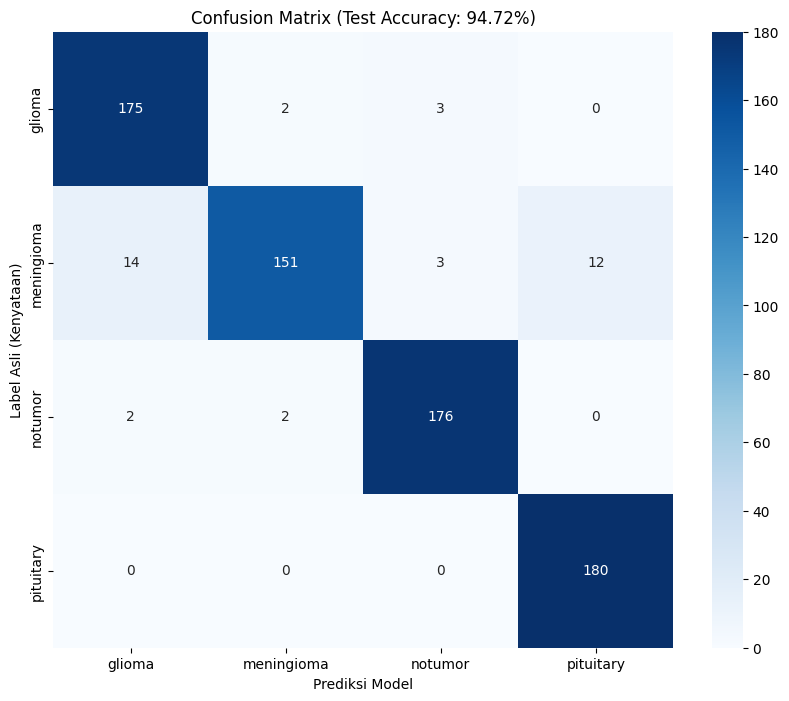


Laporan Detail per Kelas:
              precision    recall  f1-score   support

      glioma       0.92      0.97      0.94       180
  meningioma       0.97      0.84      0.90       180
     notumor       0.97      0.98      0.97       180
   pituitary       0.94      1.00      0.97       180

    accuracy                           0.95       720
   macro avg       0.95      0.95      0.95       720
weighted avg       0.95      0.95      0.95       720



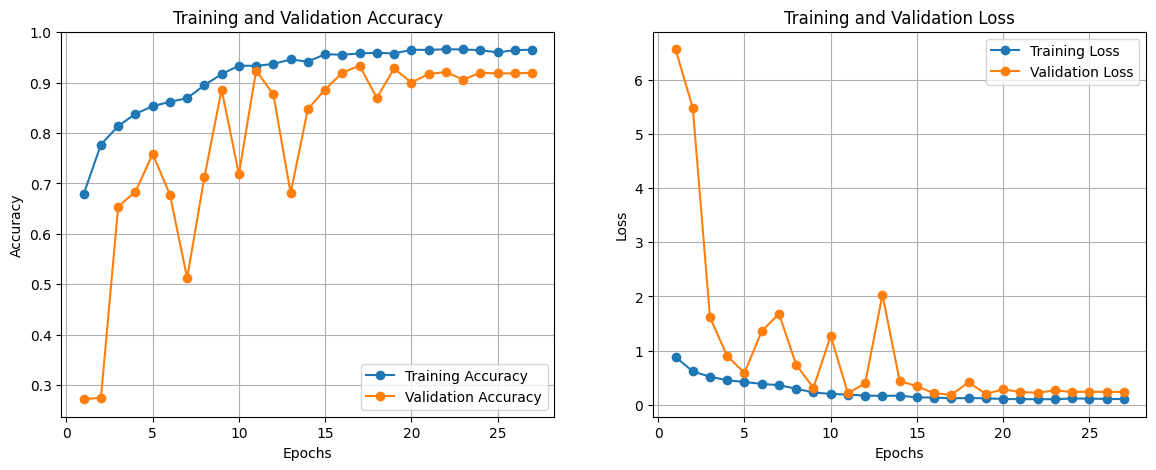

In [30]:
# A. EVALUASI AKURASI TEST SET
print("Sedang mengevaluasi model pada Test Set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n========================================")
print(f" FINAL TEST ACCURACY: {test_acc * 100:.2f}%")
print(f" FINAL TEST LOSS: {test_loss:.4f}")
print(f"========================================")

# B. PREDIKSI UNTUK CONFUSION MATRIX
y_true = []
y_pred = []

# Iterasi dataset test untuk mengambil label dan prediksi
for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Nama Kelas
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


# C. PLOT CONFUSION MATRIX
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)

# Heatmap Visualisasi
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Kenyataan)')
plt.title(f'Confusion Matrix (Test Accuracy: {test_acc*100:.2f}%)')
plt.show()

# D. LAPORAN KLASIFIKASI DETAIL
print("\nLaporan Detail per Kelas:")
print(classification_report(y_true, y_pred, target_names=class_names))

import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # --- PLOT AKURASI ---
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # --- PLOT LOSS ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Jalankan fungsi
plot_training_history(history)

## Konversi Model

In [41]:
# Konfigurasi Path
# Pastikan file .keras sudah ada di environment Kaggle (biasanya di /kaggle/working/)
model_path = 'best_brain_tumor_final.keras'
output_dir = 'submission_model'
zip_filename = 'submission_bundle'

# Bersihkan direktori output lama jika ada
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# 1. Load Model
print(f"Loading model from {model_path}...")
try:
    model = tf.keras.models.load_model(model_path, compile=False)
except:
    # Fallback jika path absolut diperlukan
    model = tf.keras.models.load_model(os.path.join('/kaggle/working', model_path), compile=False)
print("Model loaded successfully.")

# 2. Export ke SavedModel
print("Exporting to SavedModel format...")
saved_model_path = os.path.join(output_dir, 'saved_model')
try:
    model.export(saved_model_path)
except AttributeError:
    model.save(saved_model_path, save_format='tf')

# 3. Export ke TF-Lite
print("Exporting to TF-Lite format...")
tflite_path = os.path.join(output_dir, 'model.tflite')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# 4. Export ke TFJS
print("Exporting to TensorFlow.js format...")
tfjs_path = os.path.join(output_dir, 'tfjs_model')
tfjs.converters.save_keras_model(model, tfjs_path)

# 5. Kompresi ke ZIP
print("Compressing files to ZIP...")
shutil.make_archive(zip_filename, 'zip', output_dir)

print("Process complete.")
print("Click the link below to download:")

# 6. Buat Link Download Khusus Kaggle
FileLink(f'{zip_filename}.zip')

Loading model from best_brain_tumor_final.keras...
Model loaded successfully.
Exporting to SavedModel format...
Saved artifact at 'submission_model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140027927052560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927053904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927054480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927056016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927055056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927054288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927053328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927054864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140027927054096: TensorSpe

W0000 00:00:1771343488.462485      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1771343488.462552      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Exporting to TensorFlow.js format...
failed to lookup keras version from the file,
    this is likely a weight only file
Compressing files to ZIP...
Process complete.
Click the link below to download:


/kaggle/working/submission_bundle.zip

## Inference (Optional)

 Menampilkan prediksi dari Test Set...


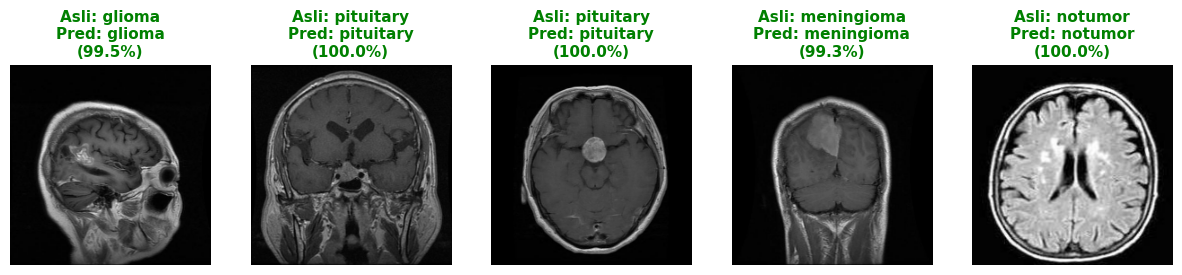

In [47]:
# Pastikan class names sesuai urutan abjad folder asli
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

def visualize_model_predictions(model, dataset, num_images=5):
    plt.figure(figsize=(15, 6))
    
    # 1. Ambil 1 batch data dari test_ds (biasanya isi 32 gambar)
    image_batch, label_batch = next(iter(dataset))
    
    # 2. Konversi ke numpy array agar bisa diproses matplotlib
    image_batch = image_batch.numpy()
    label_batch = label_batch.numpy()
    
    # 3. Loop untuk menampilkan gambar
    for i in range(min(num_images, len(image_batch))):
        ax = plt.subplot(1, num_images, i + 1)
        
        # Ambil gambar individual
        img = image_batch[i]
        
        # --- PREDIKSI ---
        # Tambah dimensi batch: (224, 224, 3) -> (1, 224, 224, 3)
        img_input = np.expand_dims(img, axis=0)
        
        predictions = model.predict(img_input, verbose=0)
        score = tf.nn.softmax(predictions[0])
        
        # Ambil index kelas tertinggi
        pred_idx = np.argmax(predictions)
        true_idx = int(label_batch[i])
        
        pred_label = CLASS_NAMES[pred_idx]
        true_label = CLASS_NAMES[true_idx]
        confidence = 100 * np.max(predictions)
        
        # --- VISUALISASI ---
        # Konversi ke uint8 (0-255) agar warna tampil benar di matplotlib
        plt.imshow(img.astype("uint8"))
        plt.axis("off")

        
        # Warna teks: Hijau jika Benar, Merah jika Salah
        color = 'green' if pred_label == true_label else 'red'
        
        plt.title(f"Asli: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                  color=color, fontsize=11, fontweight='bold')

# Jalankan fungsi
print(" Menampilkan prediksi dari Test Set...")
visualize_model_predictions(model, test_ds, num_images=5)